In [30]:
from numba import cuda,float32
import numpy as np
from PIL import Image
from matplotlib import pyplot
import math

Using the prewitt operator for edge detection. We do two passes over the image, once each with the x & y axis filters

In [31]:
ed_prewitt_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ed_prewitt_y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
threadsperblock = (16, 16)

(683, 910)

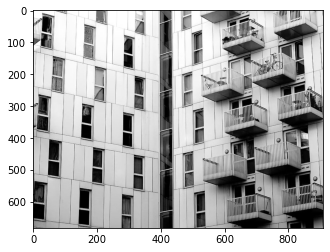

In [32]:
image = Image.open('../images/apartment.jpg')
pyplot.imshow(image,cmap = pyplot.cm.gray)
input_image = np.array(image)[:,:,0]
input_image.shape

In [33]:
def get_dim(image):
    blockspergrid_x = math.ceil(image.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(image.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    return blockspergrid,threadsperblock

Too many memory accesses to the global memory.

Using shared memory for accessing neighbouring values within within the block. Reads from shared memory are significantly faster than the global memory

In [34]:
@cuda.jit
def fast_prewitt_kernel(d_input, d_output,axis):
    if axis[0] == 0:
        mask = cuda.const.array_like(ed_prewitt_x)
    else:
        mask = cuda.const.array_like(ed_prewitt_y)
    shared_array = cuda.shared.array(shape=threadsperblock, dtype=float32)
    x, y = cuda.grid(2)
    local_x = cuda.threadIdx.x
    local_y = cuda.threadIdx.y
    rows, columns = d_input.shape
    if x > rows or y > columns:
        return
    shared_array[local_x, local_y] = d_input[x, y]
    cuda.syncthreads()
    tile_start_x = cuda.blockDim.x * cuda.blockIdx.x
    tile_start_y = cuda.blockDim.y * cuda.blockIdx.y
    tile_end_x = tile_start_x + threadsperblock[0]
    tile_end_y = tile_start_y + threadsperblock[0]
    mask_start_x = x - mask.shape[0] // 2
    mask_start_y = y - mask.shape[1] // 2
    res = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            x_index = mask_start_x + k
            y_index = mask_start_y + l
            if x_index >= 0 and x_index < rows and y_index >= 0 and y_index < columns:
                if (
                    x_index >= tile_start_x
                    and x_index < tile_end_x
                    and y_index >= tile_end_y
                    and y_index < tile_end_y
                ):
                    res += (
                        mask[k, l]
                        * shared_array[local_x + k - mask.shape[0] // 2, local_y + l - mask.shape[1] // 2]
                    )
                else:
                    res += mask[k, l] * d_input[x_index, y_index]
    if x < rows and y < columns:
        d_output[x, y] = res
    return

In [35]:
d_input = cuda.to_device(np.ascontiguousarray(input_image))
d_axis_x = cuda.to_device(np.array([0]))
d_axis_y = cuda.to_device(np.array([1]))
d_output = cuda.device_array(input_image.shape)
blockspergrid, threadsperblock = get_dim(input_image)
d_output_final = cuda.device_array(input_image.shape)

Passing the intermediate output as input to the 2nd kernel invokation

In [37]:
fast_prewitt_kernel[blockspergrid, threadsperblock](d_input, d_output,d_axis_x)
fast_prewitt_kernel[blockspergrid, threadsperblock](d_output, d_output_final, d_axis_y)

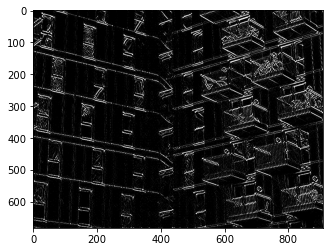

In [40]:
output = d_output_final.copy_to_host()
pyplot.imshow(Image.fromarray(output))